In [1]:
'''
The code is modified from
https://github.com/xiaohu2015/nngen/blob/main/models/diffusion_models,
https://github.com/TeaPearce/Conditional_Diffusion_MNIST,
https://www.bilibili.com/video/BV1b541197HX/

Diffusion model is based on "CLASSIFIER-FREE DIFFUSION GUIDANCE" and "Denoising Diffusion Implicit Models"
https://arxiv.org/abs/2207.12598,
https://arxiv.org/abs/2010.02502
'''

import os
import math
from abc import abstractmethod

from PIL import Image
import requests
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# use sinusoidal position embedding to encode time step (https://arxiv.org/abs/1706.03762)   
def timestep_embedding(timesteps, dim, max_period=10000):
    """
    Create sinusoidal timestep embeddings.
    :param timesteps: a 1-D Tensor of N indices, one per batch element.
                      These may be fractional.
    :param dim: the dimension of the output.
    :param max_period: controls the minimum frequency of the embeddings.
    :return: an [N x dim] Tensor of positional embeddings.
    """
    half = dim // 2
    freqs = torch.exp(
        -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
    ).to(device=timesteps.device)
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding

In [3]:
# define TimestepEmbedSequential to support `time_emb` as extra input
class TimestepBlock(nn.Module):
    @abstractmethod
    def foward(self, x, emb):
        """
        Apply the module to `x` given `emb` timestep embeddings.
        """

class TimestepEmbedSequential(nn.Sequential, TimestepBlock):
    """
    A sequential module that passes timestep embeddings to the children that
    support it as an extra input.
    """
    
    def forward(self, x, t_emb, c_emb, mask):
        for layer in self:
            if(isinstance(layer, TimestepBlock)):
                x = layer(x, t_emb, c_emb, mask)
            else:
                x = layer(x)
        return x

def norm_layer(channels):
    return nn.GroupNorm(32, channels)

In [4]:
# Residual block
class Residual_block(TimestepBlock):
    def __init__(self, in_channels, out_channels, time_channels, class_channels, dropout):
        super().__init__()
        self.conv1 = nn.Sequential(
            norm_layer(in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        )
        
        self.time_emb = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_channels, out_channels)
        )
        
        self.class_emb = nn.Sequential(
            nn.SiLU(),
            nn.Linear(class_channels, out_channels)  
        )
        
        
        self.time_emb = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_channels, out_channels)
        )
        
        self.conv2 = nn.Sequential(
            norm_layer(out_channels),
            nn.SiLU(),
            nn.Dropout(p=dropout),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        )
        
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.shortcut = nn.Identity()
        
    def forward(self, x, t, c, mask):
        """
        `x` has shape `[batch_size, in_dim, height, width]`
        `t` has shape `[batch_size, time_dim]`
        `c` has shape `[batch_size, class_dim]`
        `mask` has shape `[batch_size, ]`
        """
        h = self.conv1(x)
        emb_t = self.time_emb(t)
        emb_c = self.class_emb(c)*mask[:, None]
        h += (emb_t[:,:, None, None] + emb_c[:,:, None, None])
        h = self.conv2(h)
        
        return h + self.shortcut(x)

In [5]:
# Attention block with shortcut
class AttentionBlock(nn.Module):
    def __init__(self, channels, num_heads=1):
        super().__init__()
        self.num_heads = num_heads
        assert channels % num_heads == 0
        
        self.norm = norm_layer(channels)
        self.qkv = nn.Conv2d(channels, channels * 3, kernel_size=1, bias=False)
        self.proj = nn.Conv2d(channels, channels, kernel_size=1)

    def forward(self, x):
        B, C, H, W = x.shape
        qkv = self.qkv(self.norm(x))
        q, k, v = qkv.reshape(B*self.num_heads, -1, H*W).chunk(3, dim=1)
        scale = 1. / math.sqrt(math.sqrt(C // self.num_heads))
        attn = torch.einsum("bct,bcs->bts", q * scale, k * scale)
        attn = attn.softmax(dim=-1)
        h = torch.einsum("bts,bcs->bct", attn, v)
        h = h.reshape(B, -1, H, W)
        h = self.proj(h)
        return h + x

In [6]:
# upsample
class Upsample(nn.Module):
    def __init__(self, channels, use_conv):
        super().__init__()
        self.use_conv = use_conv
        if use_conv:
            self.conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        if self.use_conv:
            x = self.conv(x)
        return x

# downsample
class Downsample(nn.Module):
    def __init__(self, channels, use_conv):
        super().__init__()
        self.use_conv = use_conv
        if use_conv:
            self.op = nn.Conv2d(channels, channels, kernel_size=3, stride=2, padding=1)
        else:
            self.op = nn.AvgPool2d(stride=2)

    def forward(self, x):
        return self.op(x)

In [7]:
class UnetModel(nn.Module):
    def __init__(self,
                 in_channels=3,
                 model_channels=128,
                 out_channels=3,
                 num_res_blocks=2,
                 attention_resolutions=(8,16),
                 dropout=0,
                 channel_mult=(1,2,2,2),
                 conv_resample=True,
                 num_heads=4,
                 class_num=10
                ):
        super().__init__()
        self.in_channels = in_channels
        self.model_channels = model_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions
        self.dropout = dropout
        self.channel_mult = channel_mult
        self.conv_resample = conv_resample
        self.num_heads = num_heads
        self.class_num = class_num
        
        #time embedding
        time_emb_dim = model_channels*4
        self.time_emb = nn.Sequential(
                nn.Linear(model_channels, time_emb_dim),
                nn.SiLU(),
                nn.Linear(time_emb_dim, time_emb_dim)
        )
        
        #class embedding
        class_emb_dim = model_channels
        self.class_emb = nn.Embedding(class_num, class_emb_dim)
        
        #down blocks
        self.down_blocks = nn.ModuleList([
            TimestepEmbedSequential(nn.Conv2d(in_channels, model_channels, kernel_size=3, padding=1))
        ])
        down_block_channels = [model_channels]
        ch = model_channels
        ds = 1
        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                layers = [Residual_block(ch, model_channels*mult, time_emb_dim, class_emb_dim, dropout)]
                ch = model_channels*mult
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads))
                self.down_blocks.append(TimestepEmbedSequential(*layers))
                down_block_channels.append(ch)
            if level != len(channel_mult)-1: # don't use downsample for the last stage
                self.down_blocks.append(TimestepEmbedSequential(Downsample(ch, conv_resample)))
                down_block_channels.append(ch)
                ds*=2
                
        #middle blocks
        self.middle_blocks = TimestepEmbedSequential(
            Residual_block(ch, ch, time_emb_dim, class_emb_dim, dropout), 
            AttentionBlock(ch, num_heads),
            Residual_block(ch, ch, time_emb_dim, class_emb_dim, dropout)
        )
        
        #up blocks
        self.up_blocks = nn.ModuleList([])
        for level, mult in enumerate(channel_mult[::-1]):
            for i in range(num_res_blocks+1):
                layers = [
                    Residual_block(ch+down_block_channels.pop(), model_channels*mult,\
                                   time_emb_dim, class_emb_dim, dropout)]
                ch = model_channels*mult
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads))
                if level!=len(channel_mult)-1 and i==num_res_blocks:
                    layers.append(Upsample(ch, conv_resample))
                    ds //= 2
                self.up_blocks.append(TimestepEmbedSequential(*layers))
                
        self.out = nn.Sequential(
            norm_layer(ch),
            nn.SiLU(),
            nn.Conv2d(ch, out_channels, kernel_size=3, padding=1)
        )
    
    def forward(self, x, timesteps, c, mask):
        """
        Apply the model to an input batch.
        :param x: an [N x C x H x W] Tensor of inputs.
        :param timesteps: a 1-D batch of timesteps.
        :param c: a 1-D batch of classes.
        :param mask: a 1-D batch of conditioned/unconditioned.
        :return: an [N x C x ...] Tensor of outputs.
        """
        hs = []
        # time step and class embedding
        t_emb = self.time_emb(timestep_embedding(timesteps, dim=self.model_channels))
        c_emb = self.class_emb(c)
        
        
        # down stage
        h = x
        for module in self.down_blocks:
            h = module(h, t_emb, c_emb, mask)
#             print(h.shape)
            hs.append(h)
        
        # middle stage
        h = self.middle_blocks(h, t_emb, c_emb, mask)
        
        # up stage
        for module in self.up_blocks:
#             print(h.shape, hs[-1].shape)
            cat_in = torch.cat([h, hs.pop()], dim=1)
            h = module(cat_in, t_emb, c_emb, mask)
        
        return self.out(h)

In [8]:
# beta schedule
def linear_beta_schedule(timesteps):
    scale = 1000 / timesteps
    beta_start = scale * 0.0001
    beta_end = scale * 0.02
    return torch.linspace(beta_start, beta_end, timesteps, dtype=torch.float64)

def sigmoid_beta_schedule(timesteps):
    betas = torch.linspace(-6, 6, timesteps)
    betas = torch.sigmoid(betas)/(betas.max()-betas.min())*(0.02-betas.min())/10
    return betas

def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule
    as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps, dtype=torch.float64)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)

In [54]:
class GaussianDiffusion:
    def __init__(
        self,
        timesteps=1000,
        beta_schedule='linear'
    ):
        self.timesteps = timesteps
        
        if beta_schedule == 'linear':
            betas = linear_beta_schedule(timesteps)
        elif beta_schedule == 'cosine':
            betas = cosine_beta_schedule(timesteps)
        elif beta_schedule == 'sigmoid':
            betas = sigmoid_beta_schedule(timesteps)
        else:
            raise ValueError(f'unknown beta schedule {beta_schedule}')
        self.betas = betas
            
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.)
        
        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        self.log_one_minus_alphas_cumprod = torch.log(1.0 - self.alphas_cumprod)
        self.sqrt_recip_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod)
        self.sqrt_recipm1_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod - 1)
        
        # calculations for posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = (
            self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        # below: log calculation clipped because the posterior variance is 0 at the beginning
        # of the diffusion chain
        #self.posterior_log_variance_clipped = torch.log(self.posterior_variance.clamp(min =1e-20))
        self.posterior_log_variance_clipped = torch.log(
            torch.cat([self.posterior_variance[1:2], self.posterior_variance[1:]])
        )
        
        self.posterior_mean_coef1 = (
            self.betas * torch.sqrt(self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        self.posterior_mean_coef2 = (
            (1.0 - self.alphas_cumprod_prev)
            * torch.sqrt(self.alphas)
            / (1.0 - self.alphas_cumprod)
        )
    
    # get the param of given timestep t
    def _extract(self, a, t, x_shape):
        batch_size = t.shape[0]
        out = a.to(t.device).gather(0, t).float()
        out = out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))
        return out
    
    # forward diffusion (using the nice property): q(x_t | x_0)
    def q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)

        sqrt_alphas_cumprod_t = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape)
        sqrt_one_minus_alphas_cumprod_t = self._extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape)

        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise
    
    # Get the mean and variance of q(x_t | x_0).
    def q_mean_variance(self, x_start, t):
        mean = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
        variance = self._extract(1.0 - self.alphas_cumprod, t, x_start.shape)
        log_variance = self._extract(self.log_one_minus_alphas_cumprod, t, x_start.shape)
        return mean, variance, log_variance
    
    # Compute the mean and variance of the diffusion posterior: q(x_{t-1} | x_t, x_0)
    def q_posterior_mean_variance(self, x_start, x_t, t):
        posterior_mean = (
            self._extract(self.posterior_mean_coef1, t, x_t.shape) * x_start
            + self._extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = self._extract(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = self._extract(self.posterior_log_variance_clipped, t, x_t.shape)
        return posterior_mean, posterior_variance, posterior_log_variance_clipped
    
    # compute x_0 from x_t and pred noise: the reverse of `q_sample`
    def predict_start_from_noise(self, x_t, t, noise):
        return (
            self._extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t -
            self._extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
        )
    
    # compute predicted mean and variance of p(x_{t-1} | x_t)
    def p_mean_variance(self, model, x_t, t, c, w, clip_denoised=True):
        device = next(model.parameters()).device
        batch_size = x_t.shape[0]
        # predict noise using model
        pred_noise_c = model(x_t, t, c, torch.ones(batch_size).int().to(device))
        pred_noise_none = model(x_t, t, c, torch.zeros(batch_size).int().to(device))
        pred_noise = (1+w)*pred_noise_c - w*pred_noise_none
        
        # get the predicted x_0: different from the algorithm2 in the paper
        x_recon = self.predict_start_from_noise(x_t, t, pred_noise)
        if clip_denoised:
            x_recon = torch.clamp(x_recon, min=-1., max=1.)
        model_mean, posterior_variance, posterior_log_variance = \
                    self.q_posterior_mean_variance(x_recon, x_t, t)
        return model_mean, posterior_variance, posterior_log_variance
        
    # denoise_step: sample x_{t-1} from x_t and pred_noise
    @torch.no_grad()
    def p_sample(self, model, x_t, t, c, w, clip_denoised=True):
        # predict mean and variance
        model_mean, _, model_log_variance = self.p_mean_variance(model, x_t, t,
                                                c, w, clip_denoised=clip_denoised)
        noise = torch.randn_like(x_t)
        # no noise when t == 0
        nonzero_mask = ((t != 0).float().view(-1, *([1] * (len(x_t.shape) - 1))))
        # compute x_{t-1}
        pred_img = model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise
        return pred_img
    
    # denoise: reverse diffusion
    @torch.no_grad()
    def p_sample_loop(self, model, shape, n_class=10, w=2, mode='random', clip_denoised=True):
        batch_size = shape[0]
        device = next(model.parameters()).device
        
        # generate labels
        if mode == 'random':
            cur_y = torch.randint(0, n_class, (batch_size,)).to(device)
        elif mode == 'all':
            if batch_size%n_class!=0:
                batch_size = n_class
                print('change batch_size to', n_class)
            cur_y = torch.tensor([x for x in range(n_class)]*(batch_size//n_class), dtype=torch.long).to(device)
        else:
            cur_y = torch.ones(batch_size).long().to(device)*int(mode)
        
        # start from pure noise (for each example in the batch)
        img = torch.randn(shape, device=device)
        imgs = []
        for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
            img = self.p_sample(model, img, torch.full((batch_size,), i, device=device, dtype=torch.long), cur_y, w, clip_denoised)
            imgs.append(img.cpu().numpy())
        return imgs
    
    # sample new images
    @torch.no_grad()
    def sample(self, model, image_size, batch_size=8, channels=3, n_class=10, w=2, mode='random', clip_denoised=True):
        return self.p_sample_loop(model, (batch_size, channels, image_size, image_size), n_class, w, mode, clip_denoised)
    
    # use ddim to sample
    @torch.no_grad()
    def ddim_sample(
        self,
        model,
        image_size,
        batch_size=8,
        channels=3,
        ddim_timesteps=50,
        n_class = 10,
        w = 2,
        mode= 'random',
        ddim_discr_method="uniform",
        ddim_eta=0.0,
        clip_denoised=True):
        # make ddim timestep sequence
        if ddim_discr_method == 'uniform':
            c = self.timesteps // ddim_timesteps
            ddim_timestep_seq = np.asarray(list(range(0, self.timesteps, c)))
        elif ddim_discr_method == 'quad':
            ddim_timestep_seq = (
                (np.linspace(0, np.sqrt(self.timesteps * .8), ddim_timesteps)) ** 2
            ).astype(int)
        else:
            raise NotImplementedError(f'There is no ddim discretization method called "{ddim_discr_method}"')
        # add one to get the final alpha values right (the ones from first scale to data during sampling)
        ddim_timestep_seq = ddim_timestep_seq + 1
        # previous sequence
        ddim_timestep_prev_seq = np.append(np.array([0]), ddim_timestep_seq[:-1])
        
        device = next(model.parameters()).device
        
        # generate labels
        if mode == 'random':
            cur_y = torch.randint(0, n_class, (batch_size,)).to(device)
        elif mode == 'all':
            if batch_size%n_class!=0:
                batch_size = n_class
                print('change batch_size to', n_class)
            cur_y = torch.tensor([x for x in range(n_class)]*(batch_size//n_class), dtype=torch.long).to(device)
        else:
            cur_y = torch.ones(batch_size).long().to(device)*int(mode)
        
        # start from pure noise (for each example in the batch)
        sample_img = torch.randn((batch_size, channels, image_size, image_size), device=device)
        seq_img = [sample_img.cpu().numpy()]
        
        for i in tqdm(reversed(range(0, ddim_timesteps)), desc='sampling loop time step', total=ddim_timesteps):
            t = torch.full((batch_size,), ddim_timestep_seq[i], device=device, dtype=torch.long)
            prev_t = torch.full((batch_size,), ddim_timestep_prev_seq[i], device=device, dtype=torch.long)
            
            # 1. get current and previous alpha_cumprod
            alpha_cumprod_t = self._extract(self.alphas_cumprod, t, sample_img.shape)
            alpha_cumprod_t_prev = self._extract(self.alphas_cumprod, prev_t, sample_img.shape)
    
            # 2. predict noise using model
            pred_noise_c = model(sample_img, t, cur_y, torch.ones(batch_size).int().cuda())
            pred_noise_none = model(sample_img, t, cur_y, torch.zeros(batch_size).int().cuda())
            pred_noise = (1+w)*pred_noise_c - w*pred_noise_none
            
            # 3. get the predicted x_0
            pred_x0 = (sample_img - torch.sqrt((1. - alpha_cumprod_t)) * pred_noise) / torch.sqrt(alpha_cumprod_t)
            if clip_denoised:
                pred_x0 = torch.clamp(pred_x0, min=-1., max=1.)
            
            # 4. compute variance: "sigma_t(η)" -> see formula (16)
            # σ_t = sqrt((1 − α_t−1)/(1 − α_t)) * sqrt(1 − α_t/α_t−1)
            sigmas_t = ddim_eta * torch.sqrt(
                (1 - alpha_cumprod_t_prev) / (1 - alpha_cumprod_t) * (1 - alpha_cumprod_t / alpha_cumprod_t_prev))
            
            # 5. compute "direction pointing to x_t" of formula (12)
            pred_dir_xt = torch.sqrt(1 - alpha_cumprod_t_prev - sigmas_t**2) * pred_noise
            
            # 6. compute x_{t-1} of formula (12)
            x_prev = torch.sqrt(alpha_cumprod_t_prev) * pred_x0 + pred_dir_xt + sigmas_t * torch.randn_like(sample_img)

            sample_img = x_prev
            if mode == 'all':
                seq_img.append(sample_img.cpu().numpy())
            
        if mode == 'all':
            return seq_img
        else:
            return sample_img.cpu().numpy()
    
    # compute train losses
    def train_losses(self, model, x_start, t, c, mask_c):
        # generate random noise
        noise = torch.randn_like(x_start)
        # get x_t
        x_noisy = self.q_sample(x_start, t, noise=noise)
        predicted_noise = model(x_noisy, t, c, mask_c)
        loss = F.mse_loss(noise, predicted_noise)
        return loss

In [10]:
batch_size = 128
timesteps = 500

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# use MNIST dataset
dataset = datasets.MNIST(root='./dataset/mnist/', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# define model and diffusion
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UnetModel(
    in_channels=1,
    model_channels=96,
    out_channels=1,
    channel_mult=(1, 2, 2),
    attention_resolutions=[],
    class_num=10
)
model.to(device)

gaussian_diffusion = GaussianDiffusion(timesteps=timesteps)

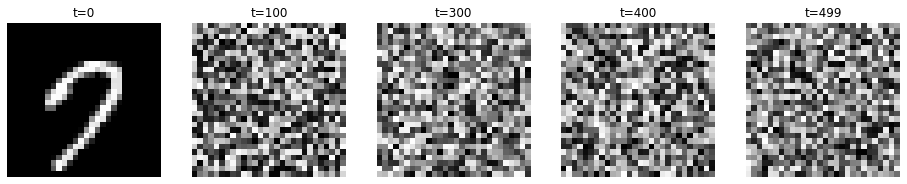

In [13]:
image = next(iter(train_loader))[0][0].squeeze()
label = next(iter(train_loader))[1][0].squeeze()

x_start = image

gaussian_diffusion = GaussianDiffusion(timesteps=500, beta_schedule='linear')

plt.figure(figsize=(16, 5))
for idx, t in enumerate([0, 100, 300, 400, 499]):
    x_noisy = gaussian_diffusion.q_sample(x_start.to(device), t=torch.tensor([t]).to(device))
    noisy_image = (x_noisy.squeeze() + 1) * 127.5
    if idx==0:
        noisy_image = (x_start.squeeze() + 1) * 127.5
    noisy_image = noisy_image.cpu().numpy().astype(np.uint8)
    plt.subplot(1, 5, 1 + idx)
    plt.imshow(noisy_image, cmap='gray')
    plt.axis("off")
    plt.title(f"t={t}")

In [17]:
# train
epochs = 10
p_uncound = 0.2
len_data = len(train_loader)
time_end = time.time()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(epochs):
    for step, (images, labels) in enumerate(train_loader):     
        time_start = time_end
        
        optimizer.zero_grad()
        
        batch_size = images.shape[0]
        images = images.to(device)
        labels = labels.to(device)
        
        # random generate mask
        z_uncound = torch.rand(batch_size)
        batch_mask = (z_uncound>p_uncound).int().to(device)
        
        # sample t uniformally for every example in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()
        
        loss = gaussian_diffusion.train_losses(model, images, t, labels, batch_mask)
        
        if step % 100 == 0:
            time_end = time.time()
            print("Epoch{}/{}\t  Step{}/{}\t Loss {:.4f}\t Time {:.2f}".format(epoch+1, epochs, step+1, len_data, loss.item(), time_end-time_start))
            
        loss.backward()
        optimizer.step()

Epoch1/10	  Step1/469	 Loss 0.0586	 Time 0.07
Epoch1/10	  Step101/469	 Loss 0.0335	 Time 27.79
Epoch1/10	  Step201/469	 Loss 0.0329	 Time 27.92
Epoch1/10	  Step301/469	 Loss 0.0243	 Time 28.05
Epoch1/10	  Step401/469	 Loss 0.0271	 Time 28.01
Epoch2/10	  Step1/469	 Loss 0.0232	 Time 19.64
Epoch2/10	  Step101/469	 Loss 0.0353	 Time 28.12
Epoch2/10	  Step201/469	 Loss 0.0243	 Time 28.32
Epoch2/10	  Step301/469	 Loss 0.0298	 Time 28.29
Epoch2/10	  Step401/469	 Loss 0.0261	 Time 28.16
Epoch3/10	  Step1/469	 Loss 0.0234	 Time 19.41
Epoch3/10	  Step101/469	 Loss 0.0289	 Time 27.96
Epoch3/10	  Step201/469	 Loss 0.0206	 Time 28.03
Epoch3/10	  Step301/469	 Loss 0.0286	 Time 27.82
Epoch3/10	  Step401/469	 Loss 0.0253	 Time 28.17
Epoch4/10	  Step1/469	 Loss 0.0225	 Time 19.24
Epoch4/10	  Step101/469	 Loss 0.0259	 Time 27.91
Epoch4/10	  Step201/469	 Loss 0.0223	 Time 28.01
Epoch4/10	  Step301/469	 Loss 0.0194	 Time 28.24
Epoch4/10	  Step401/469	 Loss 0.0243	 Time 28.71
Epoch5/10	  Step1/469	 Loss 0

In [19]:
if not os.path.exists('./saved_models'):
    os.mkdir('./saved_models')
torch.save(model, './saved_models/Classifier_free_DDIM_MNIST.h5')

In [55]:
model = torch.load('./saved_models/Classifier_free_DDIM_MNIST.h5')
gaussian_diffusion = GaussianDiffusion(timesteps=500, beta_schedule='linear')

In [29]:
generated_images = gaussian_diffusion.sample(model, 28, batch_size=64, channels=1, n_class=10, w=2, mode='random', clip_denoised=False)

sampling loop time step: 100%|██████████| 500/500 [00:42<00:00, 11.89it/s]


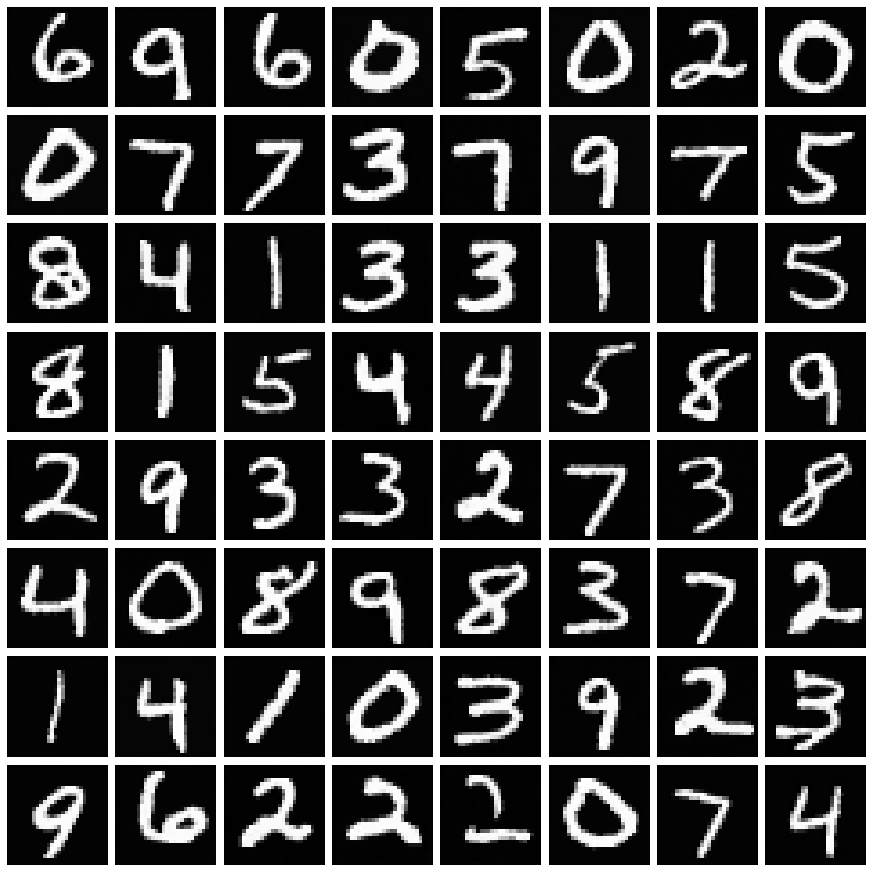

In [30]:
# generate new images
fig = plt.figure(figsize=(12, 12), constrained_layout=True)
gs = fig.add_gridspec(8, 8)

imgs = generated_images[-1].reshape(8, 8, 28, 28)
for n_row in range(8):
    for n_col in range(8):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow((imgs[n_row, n_col]+1.0) * 255 / 2, cmap="gray")
        f_ax.axis("off")

In [25]:
ddim_generated_images = gaussian_diffusion.ddim_sample(model, 28, batch_size=64, channels=1, ddim_timesteps=50, n_class=10,
                                                       w=2, mode='random', ddim_discr_method='quad', ddim_eta=0.0, clip_denoised=False)

sampling loop time step: 100%|██████████| 50/50 [00:04<00:00, 12.11it/s]


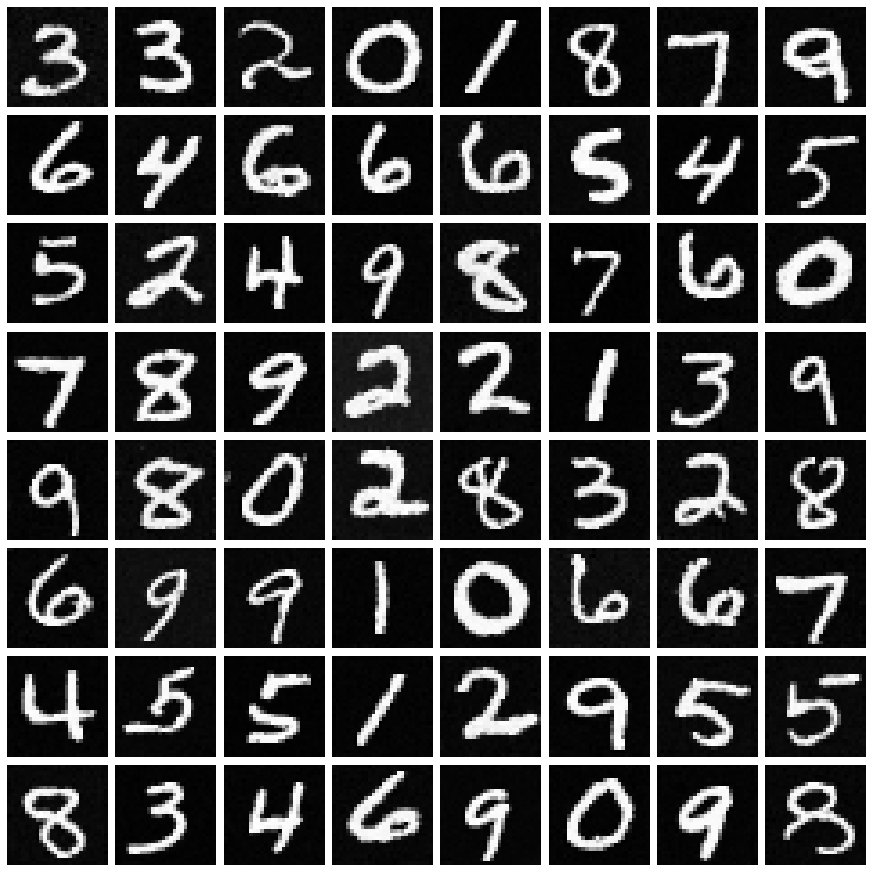

In [26]:
# ddim generate new images
fig = plt.figure(figsize=(12, 12), constrained_layout=True)
gs = fig.add_gridspec(8, 8)

imgs = ddim_generated_images.reshape(8, 8, 28, 28)
for n_row in range(8):
    for n_col in range(8):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow((imgs[n_row, n_col]+1.0) * 255 / 2, cmap="gray")
        f_ax.axis("off")

In [56]:
gif_generated_images = gaussian_diffusion.ddim_sample(model, 28, batch_size=40, channels=1, ddim_timesteps=100, n_class=10,
                                                       w=2, mode='all', ddim_discr_method='quad', ddim_eta=0.0, clip_denoised=False)

sampling loop time step: 100%|██████████| 100/100 [00:05<00:00, 16.98it/s]


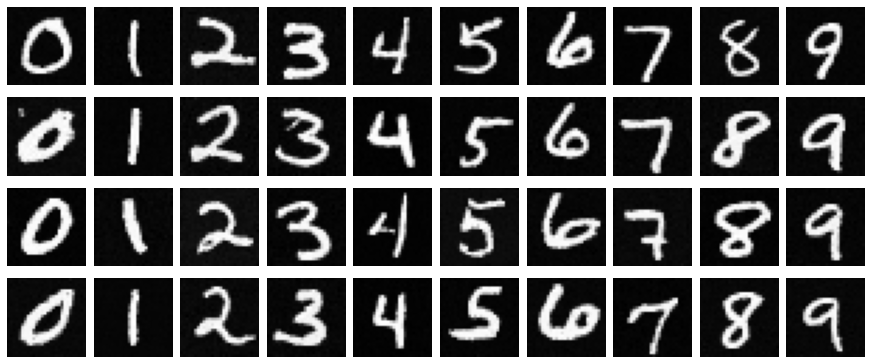

In [57]:
# ddim generate 0 1 2 3 4 5 6 7 8 9
fig = plt.figure(figsize=(12, 5), constrained_layout=True)
gs = fig.add_gridspec(4, 10)

imgs = gif_generated_images[-1].reshape(4, 10, 28, 28)
for n_row in range(4):
    for n_col in range(10):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow((imgs[n_row, n_col]+1.0) * 255 / 2, cmap="gray")
        f_ax.axis("off")

In [62]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib auto
import imageio
from glob import glob

# 生成gif
def get_imgs(x_seq, imgs_path, h, w, img_size):
    if not os.path.exists(imgs_path):
        os.mkdir(imgs_path)
    for i in tqdm(range(len(x_seq)), desc='generate gif time step', total=len(x_seq)):
        fig = plt.figure(figsize=(12, 5), constrained_layout=True)
        gs = fig.add_gridspec(h, w)

        imgs = x_seq[i].reshape(h, w, img_size, img_size)
        for n_row in range(h):
            for n_col in range(w):
                f_ax = fig.add_subplot(gs[n_row, n_col])
                f_ax.imshow((imgs[n_row, n_col]+1.0) * 255 / 2, cmap="gray")
                f_ax.axis("off")
        plt.savefig('{}/{:04d}.jpg'.format(imgs_path, i), dpi=360)  
        plt.close()

def compose_gif(img_paths, output_path, fps=10):
    print(img_paths[:12])
    gif_images = []
    for path in img_paths:
        gif_images.append(imageio.imread(path))
    imageio.mimsave(output_path,gif_images,fps=fps)

def generate_dif(x_seq, img_path, output_path, fps, h, w, img_size, delete_imgs=True):
    print('start generate images')
    get_imgs(x_seq, img_path, h, w, img_size)
    print('start generate gif')
    img_path = img_path + '/*.jpg'
    img_ls = sorted(glob(img_path))
    compose_gif(img_ls, output_path, fps)
    print('start delete images')
    if delete_imgs:
        for i in img_ls:
            os.remove(i)

Using matplotlib backend: agg


In [63]:
generate_dif(gif_generated_images, './gif_generate', './gif_generate/generate_mnist.gif', 10, 4, 10, 28)

generate gif time step:   0%|          | 0/101 [00:00<?, ?it/s]

start generate images


generate gif time step: 100%|██████████| 101/101 [16:37<00:00,  9.87s/it]
<ipython-input-62-3f0e03692f3b>:29: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  gif_images.append(imageio.imread(path))


start generate gif
['./gif_generate/0000.jpg', './gif_generate/0001.jpg', './gif_generate/0002.jpg', './gif_generate/0003.jpg', './gif_generate/0004.jpg', './gif_generate/0005.jpg', './gif_generate/0006.jpg', './gif_generate/0007.jpg', './gif_generate/0008.jpg', './gif_generate/0009.jpg', './gif_generate/0010.jpg', './gif_generate/0011.jpg']
start delete images
